# Objective

Implement a neural network.


### Function implementations


* sigmoid
* softmax
* cross entropy log loss (binary and categorical)

### Optimizer implementations
* SGD
* Adam (TBD)

### Layer implementations


* Standardization
* Matmul
* Activation (sigmoid, softmax)
* Log loss output
* Batch normalization 

Mathjax formulas get corrupted in github.

### Classifier Implementations

* Binary classifiation with (matmul-loss) layers.
* Categorical classifiation with (matmul-ReLu-matmul-Relu-loss) layers.

# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

---

# Neural network overview

Structure of the network and how forward and backward propagations work.

<img src="image/nn_diagram.png" align="left">

# Concepts 

## Objective function

The network trains the layers so as to minimize the objective function ```L``` which calculates the loss. Each layer at ```i``` is a function $f_i$ which takes an input $X_i$ from a previous layer and outputs $Y_i = f(X_i)$. The post layers of the form an objective function $L_i$ for the layer: $L = L_i(Y_i)$. 


<img src="image/nn_functions.png" align="left">

## Forward path

It is the process where each layer ```i``` calculate its output $Y_i = f(X_i)$ and forward it to the next layer(s) as their input $X_{i+1}$.

## Backward path

It is the process of automatic differentication, or *back-propagation* where each layer calculates its gradient $\frac {\partial L_i(Y_i)}{\partial Y_i}$. The gradient is the impact on the objective ```L``` that $Y_i$ will make when it changes. We can apply the gradient descent $X_i = X_i - \lambda  \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i }{\partial X_i}$ to update $X_i$ that would reduce the objective ```L```.

## Cycle

A round-trip of a forward path and a backward path with a batch data-set $(X, T)$. How many cycles to happen with each batch is an implementation decision. 

## Epoch

Total cycles to consume the entire training data.

---

# Terminologies

## X
A batch input to a layer. Matrix shape is ```(N, D)```.

* ```N``` : Number of rows in a batch X, or batch size
* ```D``` : Number of features in each data in X.


## T
Labels for X. 

There are two formats available for the labels.

### One Hot Encoding (OHE) labels

When a neural network predicts a class out of ```3``` classes for an input ```x``` and the correct class is ```2```, then the label ```t``` is specified as ```t = [0, 1, 0]```.

$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

### Index labels

The label ```t``` is specified as ```t = 2``` to tell that the correct class is at the index = 2.

$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \end{align*}
$

## W
A set of weight parameters of a node in a Matmul layer. Shape is ```(M, D)```.

* ```M``` : Number of nodes in a layer



# Matrix order

Consistently use the **row-order** matrix. For instance, the weight matrix ```W``` of a Matmul layer has a shape ```(M, D)``` where each row in ```W``` represents a node in the layer. It will be efficient to use the column order matrix of shape ```(D, M)``` for ```W``` so that the matrix multiplication at a Matmul layer can be executed as ```X@W```  which is a ```shape:(N,D) @ shape:(D,M)``` operation without transpose. 

However, for the purpose of consistency and clarity, use the shape ```W:(M, D)``` although it will cause transposes ```W.T``` at the Matmul operations, and revese transposing ```dL/dW.T``` to ```dL/dW``` when updating ```W``` at the gradient descents.


---

# Python & Jupyter setups

In [53]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [54]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [55]:
import inspect
import datetime
import copy
import logging
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

### Jupyter notebook

In [56]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

%load_ext autoreload
%autoreload 2

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Matplotlib

In [57]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [58]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

---

---

# Standardization Layer
Apply standardization. The layer keeps track of the running mean and running standard deviation using momentum. They are applied at predictions.

In [59]:
from layer.normalization import Standardization

## Forward path

See the Batch Normalization below as the calculations are the same with those before the Scale and Shift $gamma * X + beta$.

## Backward path

See the Batch Normalization below as the calculations are the same with those in front of the Scale and Shift  𝑔𝑎𝑚𝑚𝑎∗𝑋+𝑏𝑒𝑡𝑎.

---

# Matmul layer

In [60]:
from layer.matmul import Matmul

## Weight

Weight initialization depends on the activation functions although the Batch Normalization may make it less significant.

* [Xavier](http://proceedings.mlr.press/v9/glorot10a) for a symmetric activation e.g. sigmod
* [He](https://arxiv.org/abs/1502.01852) for ReLu

In [61]:
from common.weights import (
    xavier,
    he,
    uniform
)

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

### Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Batch Normalization Layer

1. Standardize the input
2. Shift and scale $gamma * X + beta$

The layer can be split into:
1. Standardization layer
2. FeatureScaleShift layer


## Foward and Backward path

* [Understanding the backward pass through Batch Normalization Layer](http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
<img src="image/bn_back_propagation.png" align="left" />
<img src="image/batch_normalization_steps_small.jpg" align="left" />

In [62]:
%reload_ext autoreload
%autoreload 2

from layer.normalization import BatchNormalization
from layer.normalization import FeatureScaleShift

---

# Activation layer

In [63]:
%reload_ext autoreload
%autoreload 2

from layer.activation import (
    ReLU,
    Sigmoid
)

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

#### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

#### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Objective (Loss) Layer

The objective layer depends on the type of classification.

* Softmax Cross Entropy Log Loss for multi label classifiation
* Logistic (Sigmoid) Cross Entropy Log Loss for binary classification


In [64]:
from layer.objective import (
    CrossEntropyLogLoss
)
from common.function import (
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)

lines = inspect.getsource(softmax_cross_entropy_log_loss)
print(lines)

def softmax_cross_entropy_log_loss(
        X: Union[np.ndarray],
        T: Union[np.ndarray],
        offset: TYPE_FLOAT = TYPE_FLOAT(0),
        use_reformula: bool = True,
        need_softmax: bool = True,
        out_P=None,
        out_J=None
) -> Tuple[np.ndarray, np.ndarray]:
    """Cross entropy log loss for softmax activation -T * log(softmax(X))
    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

        Do not accept binary classification data where P is scalar or P.shape[T] = 1.
        Softmax() is for multi label classification, hence M=P.shape[1] > 1.

        P.ndim == 0 or ((1 < P.ndim == T.ndim) and (P.shape[1] == T.shape[1] == 1))
        is for binary classification.
        Run "P, T = transform_X_T(P, T)" to transform (P, T) to transform P in 1D or
        T in OHE format before calling this function.

    Formula:
        Loss J = -log( exp(xi) / sum(exp(X)) ) can be re-formulated 


## Why using entropy

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

## Softmax Layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

### Foward path
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

### Backward path

#### Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

The formula is calculated by chaing the gradient from ***cross-entropy-log-loss***, and the gradients of the steps in ***softmax***.

#### Gradient from the cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


####  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

#### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



#### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



#### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

## Label T

### One Hot Encoding (OHE) labels

For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


#### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [65]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## Index labels
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss Layer

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [66]:
N = 3
dJ = np.ones(N) / N
dJ

array([0.33333333, 0.33333333, 0.33333333])

---


# Gradient check

## Numerical gradient

The objective of back-propagation is to analytically calculate the gradient of the objective function $g(X_i) = \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i}{\partial X_i}$ at each layer. Suppose the shape of $X_i$ is ```(N, M)```. We can take an element of X at an index ```(n,m)``` and add a small change ```h```, then see what impact ```h``` makes by calculating the numerical gradient ```gn``` as: $
\begin {align*}
gn(X_i) = \frac {L_i(f_i(X_i+h)) - L_i(f_i(X_i-h))} {2h }
\end {align*}
$. Then $gn(X_i) \approx \; $gn(X_i)$ would assure the gradient calculation should be correct.

In [67]:
from common.function import (
    numerical_jacobian,
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, TYPE_FLOAT],
        delta: Optional[TYPE_FLOAT] = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix 


### Consideration

#### Instability of numerical calculations

A float number can have infinite length e.g. ```1/3``` in the real world, but a computer needs to approximate it by rounding it to fit into a limited storage. Need to assure numerical errors are prevented or detected while calculating gradient numerically. See [Numerical errors](numerical_errors.ipynb). 

### Example 

Comparing the analytical gradient and the numerical gradient of a logistic log loss ```L = -(1-T) * log(Z)``` where ```T = 0``` and ```Z=sigmoid(X)```.

In [68]:
def t_0_logistic_log_loss(X):
    """Logistic log loss function"""
    # --------------------------------------------------------------------------------
    # For numerical stability, re-forumulate the logistic log loss -(1-T)log(1-Z) as
    # X + log(1+exp(-X)).
    
    # By Reza.B
    # Let z=1/(1+p), p= e^(-x), then log(1-z)=log(p)-log(1+p), which is more stable
    # in terms of rounding errors (we got rid of division, which is the main issue 
    # in numerical instabilities). 
    # --------------------------------------------------------------------------------
    L = np.sum(X + np.log(1 + np.exp(-X)))
    return L.tolist()

def gradient_t_0_loss(X):
    return 1 / (1 + np.exp(-X))

X = np.random.uniform(-5, 5, (2,2))
print(f"The analytical and numerical gradients of the logistic log loss for X:\n{X}\n")

analytical_gradient = gradient_t_0_loss(X)
numerical_gradient = numerical_jacobian(t_0_logistic_log_loss, X)

print(f"Analytical gradient:\n{analytical_gradient}\n")
print(f"Numerical gradient:\n{numerical_gradient}")

The analytical and numerical gradients of the logistic log loss for X:
[[-2.97252811 -0.28486285]
 [ 4.06140006  2.46860043]]

Analytical gradient:
[[0.04868251 0.42926199]
 [0.98306679 0.92191107]]

Numerical gradient:
[[0.04868106 0.42926107]
 [0.98306696 0.92191144]]


---

# Classification

In [69]:
%reload_ext autoreload
%autoreload 2
from data import (
    linear_separable,
    linear_separable_sectors,
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot,
    plot_on_ax,
    scatter,
    plot_categorical_predictions
)

from common.function import (
    transform_X_T,
    prediction_grid_2d
)
from layer.constants import (
    _WEIGHTS,
    _NAME,
    _SCHEME,
    _OPTIMIZER,
    _NUM_NODES,
    _NUM_FEATURES,
    _PARAMETERS,
    _LOSS_FUNCTION,
    _COMPOSITE_LAYER_SPEC,
    _LOG_LEVEL
)
from optimizer import (
    SGD
)
from network.sequential import (
    SequentialNetwork
)

In [70]:
%matplotlib notebook

def draw_training(X, W, _ax=None, _fig=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.
    
    
def run_training(network, epoch: int, x, t, c):
    # Train
    for i in range(epoch):
        network.train(X=x, T=t)
        if not (i % 1000): 
            print(f"iteration {i} Loss {network.L}")

    fig, ax = plt.subplots(1, 2, figsize=(9,4)) 
    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()

    # Plot errors
    _x = range(len(network.history))
    _y = network.history
    xlabel = 'iterations (log scale)'
    ylabel = 'loss'
    title = "training error"
    plot_on_ax(ax[0], _x, _y, title=title, xlabel=xlabel, ylabel=ylabel)
    #ax.set_ylim(0.0, 1.5)
    ax[0].set_xscale('log')

    # Plot predictions
    x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, network.predict)
    plot_categorical_predictions(ax[1], [x_grid, y_grid], x, c, predictions)
    ax[1].axis('equal')
    ax[1].set_xlim(-3, 3)
    ax[1].set_ylim(-3, 3)
    ax[1].grid()
    ax[1].set_title("Predictions")

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

## Data X and Label T

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [71]:
N = 500    # Number of plots
D = 2      # Number of features

X_Bin, T_Bin, V_Bin = linear_separable(d=D, n=N)
x_bin_min, x_bin_max = X_Bin[:, 0].min(), X_Bin[:, 0].max()
y_bin_min, y_bin_max = X_Bin[:, 1].min(), X_Bin[:, 1].max()

Y_Bin = COLOR_LABELS[
    T_Bin
]

#X, T = transform_X_T(X, T)

### Plot the labelled data


<IPython.core.display.Javascript object>


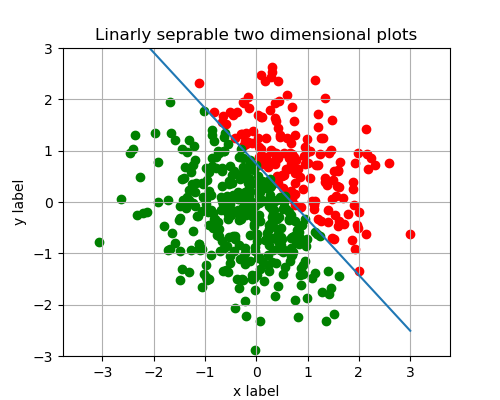

In [72]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X_Bin[T_Bin==0, 0], X_Bin[T_Bin==0, 1], c='red')
ax.scatter(X_Bin[T_Bin==1, 0], X_Bin[T_Bin==1, 1], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V_Bin[1] / V_Bin[2]) * x - (V_Bin[0] / V_Bin[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

## Construct a neural network


In [73]:
print(f"Train a sigmoid classifier to find optimal W\n{tuple(V_Bin)} for the boundary.")
M = 1

Train a sigmoid classifier to find optimal W
(0.45083815754438, -0.6562326252470744, -0.6050650355650389) for the boundary.


### Compose a neural network specification

In [74]:
sigmoid_classifier_specification = {
    _NAME: "softmax_classifier",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: {
        "matmul01": Matmul.specification(
            name="matmul", 
            num_nodes=M, 
            num_features=D, 
            weights_initialization_scheme="he",
            weights_optimizer_specification=SGD.specification(
                lr=0.2, 
                l2=1e-3
            )
        ), 
        "loss": CrossEntropyLogLoss.specification(
            name="loss", 
            num_nodes=M,
            loss_function=sigmoid_cross_entropy_log_loss.__qualname__
        )
    }
}

### Instantiate the network

In [75]:
logistic_classifier = SequentialNetwork.build(
    specification=sigmoid_classifier_specification,
)

## Run Trainig

<IPython.core.display.Javascript object>


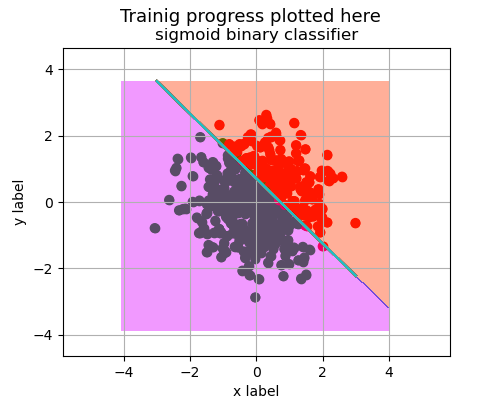

In [76]:
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(X_Bin[T_Bin==0, 0], X_Bin[T_Bin==0, 1], c='red')
ax.scatter(X_Bin[T_Bin==1, 0], X_Bin[T_Bin==1, 1], c='green')
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

fig.suptitle('Trainig progress plotted here', fontsize=13)
ax.set_title("sigmoid binary classifier")
draw_sigmoid = partial(draw_training, X=X_Bin, _fig=fig, _ax=ax)

In [77]:
MAX_TEST_TIMES = 50
for i in range(MAX_TEST_TIMES):
    logistic_classifier.train(X=X_Bin, T=T_Bin)
    draw_sigmoid(W=logistic_classifier.layer_inference.layers[0].W[0])

In [78]:
x_grid, y_grid, logistic_predictions = prediction_grid_2d(
    x_bin_min, x_bin_max, y_bin_min, y_bin_max, logistic_classifier.predict
)
plot_categorical_predictions(ax, [x_grid, y_grid], X_Bin, Y_Bin, logistic_predictions)
ax.axis('equal')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/function.py:79: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [79]:
logistic_classifier.predict(np.array([[-1., -1.]]))

array([[1]], dtype=int8)

In [80]:
del X_Bin, T_Bin, V_Bin, x_bin_min, x_bin_max, y_bin_min, y_bin_max

---

# Categorical Classification Linearly separable data

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

## Data X and Label T
Training data to linearly classify into M categories and labels T.

In [81]:
print(f"Train a categorical classifier")
N = 500
D = 2      # Dimension
M = 3

rotation = np.radians(70)
# x0 = X[::,0] is the bias 1
X_cat, T_cat, B_cat = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)
#X_cat_backup = copy.deepcopy(X_cat)
#T_cat_backup = copy.deepcopy(T_cat)

Train a categorical classifier


### Plot X, T

<IPython.core.display.Javascript object>


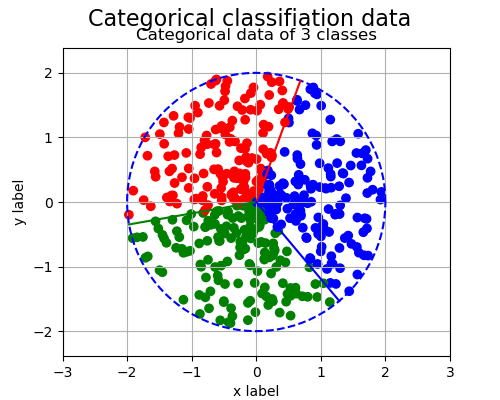

In [82]:
# Radius of a circle within which to place plots.
radius = 2   

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()
ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
# Classify plots (x, y) if inside the coverage sector
# labels to classify outside/0/red or inside/1/green.
# --------------------------------------------------------------------------------
Y_cat = COLOR_LABELS[
    T_cat
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X_cat[::,0], X_cat[::,1], marker='o', color=Y_cat)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B_cat.shape[0]):
    ax.plot((0, radius * B_cat[i, 0]), (0, radius * B_cat[i, 1]), COLOR_LABELS[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

plt.draw()
plt.show()


## Construct a neural network

### Compose a neural network specification

In [83]:
sequential_layer_specification_linear = {
    "matmul01": Matmul.specification(
        name="matmul01", 
        num_nodes=M, 
        num_features=D, 
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05, 
            l2=1e-3
        )
    ), 
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}

network_specification_linear = {
    _NAME: "two_layer_classifier",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification_linear
}

## Run training

iteration 0 Loss 1.1006303642309276


<IPython.core.display.Javascript object>


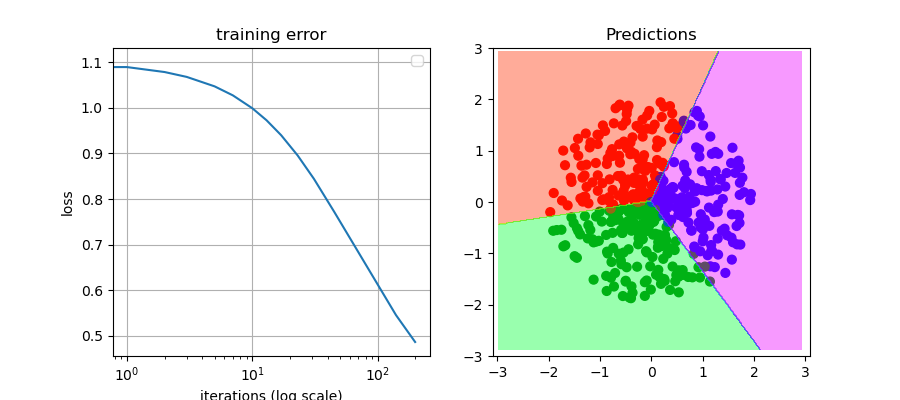

No handles with labels found to put in legend.
/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/function.py:79: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [84]:
MAX_TEST_TIMES = 200

network_linear = SequentialNetwork.build(
    specification=network_specification_linear,
)

run_training(network=network_linear, epoch=MAX_TEST_TIMES, x=X_cat, t=T_cat, c=Y_cat)

In [85]:
del network_linear, X_cat, T_cat, B_cat 

# Categorical Classification Non-Linearly separable data

In [86]:
%reload_ext autoreload
%autoreload 2

from data import (
    set_in_a_radius,
    sets_of_circle_A_not_B
)
from layer import (
    Standardization, 
    FeatureScaleShift
)

## Data X and Label T
Training data set that cannot be linearly classified. ```X = ((A not B), (B not C), (C not A), (A and B and C and D))``` for circles A, B, C.

<IPython.core.display.Javascript object>


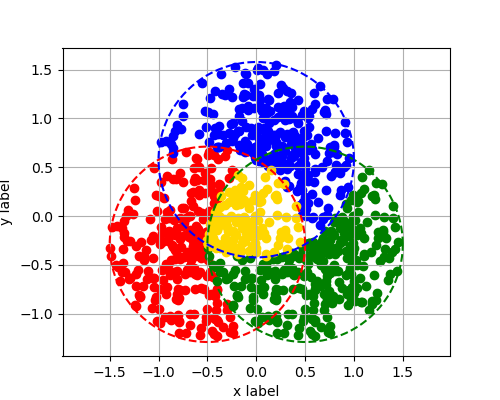

In [87]:
__M = 3        # Number of circles
__N = 500
radius = 1
circles, centres, intersection = sets_of_circle_A_not_B(radius=radius, ratio=1.0, m=__M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

# (A not B), (B not C), (C not A)
for i in range(__M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

# (A and B and C and D)
M = __M + 1
ax.scatter(intersection[::, 0], intersection[::, 1], color='gold')

In [88]:
# Stack all circles and intersect
X_cat_nl = np.vstack(
    [circles[i] for i in range(M-1)] + 
    [intersection]
)

T_cat_nl = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M-1)] + 
    [np.full(intersection.shape[0], M-1)]
)
N_cat_nl = T_cat_nl.shape[0]
assert T_cat_nl.shape[0] == X_cat_nl.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T_cat_nl.shape[0]))
X_cat_nl = X_cat_nl[indices]
T_cat_nl = T_cat_nl[indices]
Y_cat_nl = COLOR_LABELS[T_cat_nl]
X_cat_nl, T_cat_nl = transform_X_T(X_cat_nl, T_cat_nl)

print(f"X:{X_cat_nl.shape} T:{T_cat_nl.shape} ")

X:(1024, 2) T:(1024,) 


## Construct a neural network

In [89]:
MAX_TEST_TIMES = 10000
D = 2
M01 = 8
M02: int = M  # Number of categories to classify
    
W01 = he(M01, D+1)
W02 = he(M02, M01+1)

### Compose a neural network specification

A **network specification** is a JSON that specify the layers in the network and their parameters. SequentialNetwork takes the specification and instantiates the layers.

In [90]:
LAYER_INDEX_MATMUL01 = 1
LAYER_INDEX_MATMUL02 = 3

sequential_layer_specification = {
    "std01": Standardization.specification(
        name="std01",
        num_nodes=D,
        momentum=0.9
    ),
    "matmul01": Matmul.specification(
        name="matmul01", 
        num_nodes=M01, 
        num_features=D, 
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05, 
            l2=1e-3
        )
    ), 
    "relu01": ReLU.specification(
        name="relu01", 
        num_nodes=M01,     
    ),
#    "sigmoid01": Sigmoid.specification(
#        name="sigmoid01", 
#        num_nodes=M01,     
#    ),
    "matmul02": Matmul.specification(
        name="matmul02", 
        num_nodes=M02, 
        num_features=M01, 
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05, 
            l2=1e-3
        )
    ), 
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}

network_specification = {
    _NAME: "two_layer_classifier",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification
}
#import json
#print(json.dumps(network_specification, indent=4))

### Instantiate the network

In [91]:
network = SequentialNetwork.build(
    specification=network_specification,
)

# Reset the weights to use the same later in the batch normazliation version
network.layer_inference.layers[LAYER_INDEX_MATMUL01]._W = copy.deepcopy(W01) 
network.layer_inference.layers[LAYER_INDEX_MATMUL02]._W = copy.deepcopy(W02) 

np.array_equal(W01, network.layer_inference.layers[LAYER_INDEX_MATMUL01].W) and \
np.array_equal(W02, network.layer_inference.layers[LAYER_INDEX_MATMUL02].W)

True

## Run training

iteration 0 Loss 1.4934982735976632
iteration 1000 Loss 0.2905965523751889
iteration 2000 Loss 0.2378887871635592
iteration 3000 Loss 0.2041218028445192
iteration 4000 Loss 0.1793213977531513
iteration 5000 Loss 0.15944326045638615
iteration 6000 Loss 0.14281934799446622
iteration 7000 Loss 0.12885472810963117
iteration 8000 Loss 0.11725499558107451
iteration 9000 Loss 0.10777305235448034


<IPython.core.display.Javascript object>


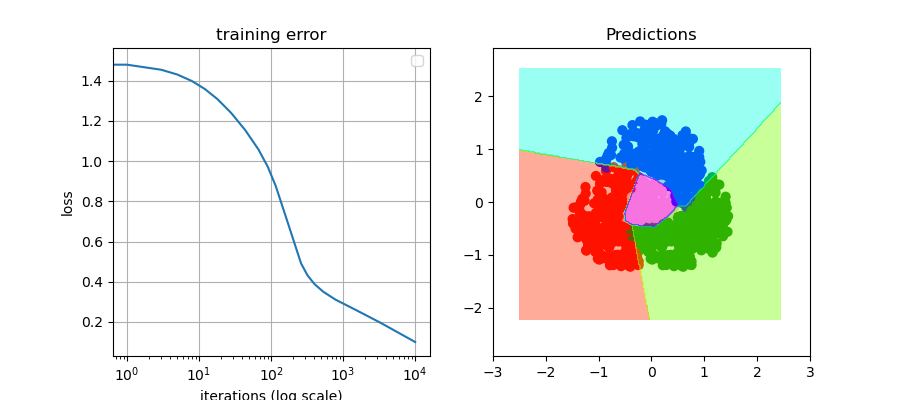

No handles with labels found to put in legend.
/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/function.py:79: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [92]:
run_training(network=network, epoch=MAX_TEST_TIMES, x=X_cat_nl, t=T_cat_nl, c=Y_cat_nl)

In [93]:
del network

# Batch normalization
Observe the effect of the batch normalization by inserting the layer in-between activation and matmul layers.

### Compose the neural network specification

In [94]:
NET_BN_LAYER_INDEX_MATMUL01 = 1
NET_BN_LAYER_INDEX_MATMUL02 = 4

sequential_layer_specification_bn = {
    "std01": Standardization.specification(
        name="std01",
        num_nodes=D,
        momentum=0.9
    ),
    "matmul01": Matmul.specification(
        name="matmul01",
        num_nodes=M01,
        num_features=D,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "bn01": BatchNormalization.specification(
        name="bn01",
        num_nodes=M01,
        gamma_optimizer_specification=SGD.specification(
            lr=0.3,
            l2=1e-3
        ),
        beta_optimizer_specification=SGD.specification(
            lr=0.3,
            l2=1e-3,
        ),
        momentum=0.9
    ),
    "relu01": ReLU.specification(
        name="relu01",
        num_nodes=M01,
    ),
#    "sigmoid01": Sigmoid.specification(
#        name="sigmoid01", 
#        num_nodes=M01,     
#    ),
    "matmul02": Matmul.specification(
        name="matmul02",
        num_nodes=M02,
        num_features=M01,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}


network_specification_bn = {
    _NAME: "two_layer_classifier_with_batch_normalization",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification_bn
}

#import json
#print(json.dumps(network_specification_bn, indent=4))

### Instantiate the network

In [95]:
network_bn = SequentialNetwork.build(
    specification=network_specification_bn,
)

# Use the same weights used in non-batch-normalization network
network_bn.layer_inference.layers[NET_BN_LAYER_INDEX_MATMUL01]._W = copy.deepcopy(W01)
network_bn.layer_inference.layers[NET_BN_LAYER_INDEX_MATMUL02]._W = copy.deepcopy(W02)

np.array_equal(W01, network_bn.layer_inference.layers[NET_BN_LAYER_INDEX_MATMUL01].W) and\
np.array_equal(W02, network_bn.layer_inference.layers[NET_BN_LAYER_INDEX_MATMUL02].W)

True

## Run training

iteration 0 Loss 1.5630951467325513
iteration 1000 Loss 0.2071352397467231
iteration 2000 Loss 0.14207890356767833
iteration 3000 Loss 0.10519730360492248
iteration 4000 Loss 0.08414564058988827
iteration 5000 Loss 0.0712068304450546
iteration 6000 Loss 0.06253059025070302
iteration 7000 Loss 0.0565484568714327
iteration 8000 Loss 0.052209380841591865
iteration 9000 Loss 0.04887336027709859


<IPython.core.display.Javascript object>


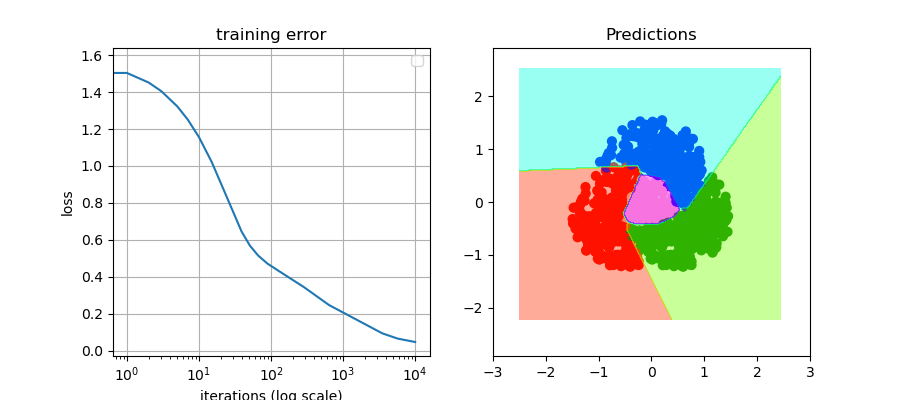

No handles with labels found to put in legend.


In [96]:
run_training(network=network_bn, epoch=MAX_TEST_TIMES, x=X_cat_nl, t=T_cat_nl, c=Y_cat_nl)

In [97]:
del network_bn

# Standardization

Instead of Batch Normailzation, place Standardization (without gamma * X + beta scaling).

In [98]:
NET_STD_LAYER_INDEX_MATMUL01 = 1
NET_STD_LAYER_INDEX_MATMUL02 = 4

sequential_layer_specification_std = {
    "std01": Standardization.specification(
        name="std01",
        num_nodes=D,
        momentum=0.9
    ),
    "matmul01": Matmul.specification(
        name="matmul01",
        num_nodes=M01,
        num_features=D,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "std02": Standardization.specification(
        name="std02",
        num_nodes=M01,
        momentum=0.9
    ),
    "relu01": ReLU.specification(
        name="relu01",
        num_nodes=M01,
    ),
    "matmul02": Matmul.specification(
        name="matmul02",
        num_nodes=M,
        num_features=M01,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}


network_specification_std = {
    _NAME: "two_layer_classifier_with_batch_normalization",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification_std
}

#import json
#print(json.dumps(network_specification_bn, indent=4))

In [99]:
network_std = SequentialNetwork.build(
    specification=network_specification_std,
)

# Use the same weights used in non-batch-normalization network
network_std.layer_inference.layers[NET_STD_LAYER_INDEX_MATMUL01]._W = copy.deepcopy(W01)
network_std.layer_inference.layers[NET_STD_LAYER_INDEX_MATMUL02]._W = copy.deepcopy(W02)

np.array_equal(W01, network_std.layer_inference.layers[NET_STD_LAYER_INDEX_MATMUL01].W) and\
np.array_equal(W02, network_std.layer_inference.layers[NET_STD_LAYER_INDEX_MATMUL02].W)

True

iteration 0 Loss 1.5630951467325513
iteration 1000 Loss 0.33344681285463557
iteration 2000 Loss 0.2885193008448306
iteration 3000 Loss 0.26471641343335095
iteration 4000 Loss 0.2500549978365195
iteration 5000 Loss 0.24005023985840812
iteration 6000 Loss 0.2327263670421187
iteration 7000 Loss 0.22707317015565032
iteration 8000 Loss 0.22252858796364244
iteration 9000 Loss 0.21873808865062444


<IPython.core.display.Javascript object>


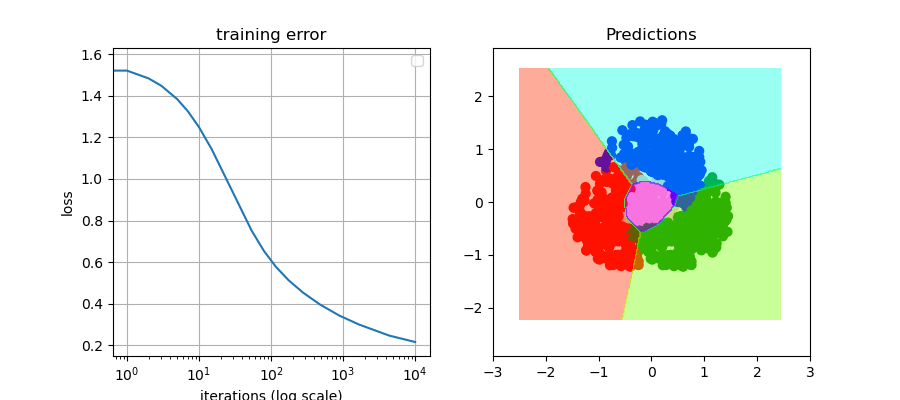

No handles with labels found to put in legend.


In [100]:
run_training(network=network_std, epoch=MAX_TEST_TIMES, x=X_cat_nl, t=T_cat_nl, c=Y_cat_nl)

In [101]:
del network_std

# Standardization + Feature Scale & Shift

Add the Feature Scale and Shift (gamma * X + beta) as in the Batcn Normalization after std02.

In [102]:
NET_STD_FSS_LAYER_INDEX_MATMUL01 = 1
NET_STD_FSS_LAYER_INDEX_MATMUL02 = 5

sequential_layer_specification_std_fss = {
    "std01": Standardization.specification(
        name="std01",
        num_nodes=D,
        momentum=0.9
    ),
    "matmul01": Matmul.specification(
        name="matmul01",
        num_nodes=M01,
        num_features=D,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "std02": Standardization.specification(
        name="std02",
        num_nodes=M01,
        momentum=0.9
    ),
    "fss02": FeatureScaleShift.specification(
        name="fss02",
        num_nodes=M01,
        gamma_optimizer_specification={
            _SCHEME: SGD.__qualname__,
            _PARAMETERS: {
                "lr": 0.3,
                "l2": 1e-3
            }
        }
    ),
    "relu01": ReLU.specification(
        name="relu01",
        num_nodes=M01,
    ),
    "matmul02": Matmul.specification(
        name="matmul02",
        num_nodes=M,
        num_features=M01,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}


network_specification_std_fss = {
    _NAME: "two_layer_classifier_with_std_fss",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification_std_fss
}

#import json
#print(json.dumps(network_specification_std_fss, indent=4))

In [103]:
network_std_fss = SequentialNetwork.build(
    specification=network_specification_std_fss,
)

# Use the same weights used in non-batch-normalization network
network_std_fss.layer_inference.layers[NET_STD_FSS_LAYER_INDEX_MATMUL01]._W = copy.deepcopy(W01)
network_std_fss.layer_inference.layers[NET_STD_FSS_LAYER_INDEX_MATMUL02]._W = copy.deepcopy(W02)

np.array_equal(W01, network_std_fss.layer_inference.layers[NET_STD_FSS_LAYER_INDEX_MATMUL01].W) and\
np.array_equal(W02, network_std_fss.layer_inference.layers[NET_STD_FSS_LAYER_INDEX_MATMUL02].W)

True

iteration 0 Loss 1.5630951467325513
iteration 1000 Loss 0.2071352397467231
iteration 2000 Loss 0.14207890356767833
iteration 3000 Loss 0.10519730360492248
iteration 4000 Loss 0.08414564058988827
iteration 5000 Loss 0.0712068304450546
iteration 6000 Loss 0.06253059025070302
iteration 7000 Loss 0.0565484568714327
iteration 8000 Loss 0.052209380841591865
iteration 9000 Loss 0.04887336027709859


<IPython.core.display.Javascript object>


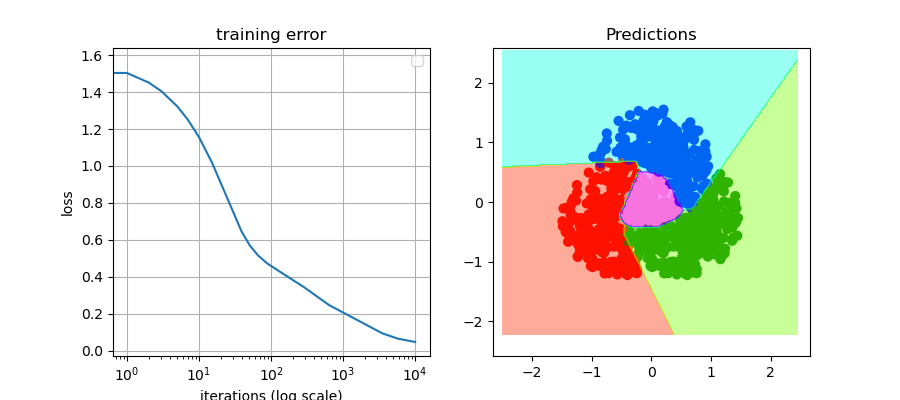

No handles with labels found to put in legend.


In [104]:
run_training(network=network_std_fss, epoch=MAX_TEST_TIMES, x=X_cat_nl, t=T_cat_nl, c=Y_cat_nl)

In [105]:
del network_std_fss, 
del X_cat_nl
del T_cat_nl
del Y_cat_nl

---

# Multi Layer Network

## Data X and Label T (MNIST)

In [106]:
from data.mnist import load_mnist 
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

# Convert to the numpy default type. Numpy cannot set the default float type globally.
X_train = x_train.astype(float)
T_train = t_train.astype(int)
X_test = x_test.astype(float)

## Construct network

In [107]:
from network.sequential import (
    SequentialNetwork
)
from network.utility import (
    multilayer_network_specification
)
from layer import ReLU

In [110]:
N = X_train.shape[0]
D = X_train.shape[1]
M01 = 32
M02 = 32
M03 = 16
M04 = 10
M = 10

specification = multilayer_network_specification([D, M01, M02, M03, M04, M])
multilayer_network = SequentialNetwork.build(
    specification=specification
)

In [112]:
import json
print(json.dumps(specification, indent=4))

{
    "name": "multilayer_network",
    "num_nodes": 10,
    "log_level": 40,
    "composite_layer_specification": {
        "std000": {
            "scheme": "Standardization",
            "parameters": {
                "name": "std000",
                "num_nodes": 784,
                "momentum": 0.9,
                "eps": 0.0,
                "log_level": 40
            }
        },
        "matmul001": {
            "scheme": "Matmul",
            "parameters": {
                "name": "matmul001",
                "num_nodes": 32,
                "num_features": 784,
                "weights": {
                    "scheme": "he"
                },
                "optimizer": {
                    "scheme": "SGD",
                    "parameters": {
                        "name": "sgd",
                        "lr": 0.05,
                        "l2": 0.001
                    }
                }
            }
        },
        "bn001": {
            "scheme": "BatchNormaliz

## Run training

In [ ]:
MAX_TEST_TIMES=500

elapsed = []
history_recall = []
for i in range(MAX_TEST_TIMES):
    start = datetime.datetime.now()

    multilayer_network.train(X=X_train, T=T_train)
    recall = np.sum(multilayer_network.predict(X_test)==t_test) / t_test.size
    history_recall.append(recall)

    end = datetime.datetime.now()
    elapsed.append(end - start)    

    if not (i % 10): 
        print(f"iteration {i:3d} Loss {multilayer_network.L:15f} Recall {recall:7f} avg {np.mean(elapsed)}")

## Plot errors

In [ ]:
_x = range(len(multilayer_network.history))
xlabel = 'iterations'
fig, ax1 = plot(
    _x, multilayer_network.history, 
    label="error", title="training error", xlabel=xlabel, ylabel='loss', scale='log', color="b",
    figsize=(5,3)
)
fig, ax2 = plot(
    _x, history_recall, 
    label="recall", title="model performance", xlabel=xlabel, ylabel='recall', scale='log', color='orange',
    figsize=(5,3)
)

## Model performance (Recall)

In [ ]:
predictions = multilayer_network.predict(X_test)
recall = np.sum(predictions==t_test) / t_test.size
recall